# HyperCC tutorial

This tutorial will show the basics of working with HyperCC!

## Prerequisites / Installation

Installation will be made easier soon! For the moment:

- Linux: HyperCC is completely untested on Windows or Mac.
- HyperCanny: Install from [GitHub:abrupt-climate/hyper-canny](github.com/abrupt-climate/hyper-canny)
- HyperCC: Install from [GitHub:abrupt-climate/hypercc](github.com/abrupt-climate/hypercc)
- Python3
- Cython
- GCC >= 7

We recommend installing HyperCanny and HyperCC into a virtual environment (see for instance: [Hitchhikers Guide to Python](http://docs.python-guide.org/en/latest/dev/virtualenvs/)). I'll assume you've run something along the lines of (your command prompt will probably look different than just `$`):

```sh
$ virtualenv -p /usr/bin/python3 climate
$ source ./climate/bin/activate
(climate) $  # "(climate)" indicates we have activated the VirtualEnv
```

Next, we need to install `numpy` to be able to compile HyperCanny.

```sh
(climate) $ pip install numpy
(climate) $ cd hyper-canny
(climate) hyper-canny$ pip install .
(climate) hyper-canny$ cd ../hypercc
(climate) hypercc$ pip install .
```

This should get you up and running! In addition, to run this notebook we need Boto3 and Pandas:

In [24]:
!pip install --quiet boto3 pandas

hypercanny-climate-module 0.1.0 requires hyper_canny, which is not installed.


## Getting data

To run this example we need to get us some climate/weather data! The UK Met Office has a public dataset on Amazon S3 called MOGREPS. I have included here a script to retrieve some of its data, It needs the `boto3` module to communicate with Amozon S3.

In [1]:
from mogreps import make_data_object_name, download_data

In [54]:
key = make_data_object_name('mogreps-g', 2016, 7, 1, 0, 0, 12)
file = download_data('mogreps-g', key)

### Exploring our data

In [32]:
import netCDF4
import pandas

The datafile contains a weather forcasts for August 1, 2016. This forecast contains many variables:

In [55]:
dataset = netCDF4.Dataset(file)

pandas.DataFrame([[
        name,
        getattr(var, 'long_name', ''),
        getattr(var, 'units', ''),
        var.shape]
        for name, var in dataset.variables.items()],
    columns=['variable', 'description', 'units', 'shape'])

,variable,description,units,shape
0,wet_bulb_freezing_level_altitude,wet_bulb_freezing_level_altitude,m,"(600, 800)"
1,latitude_longitude,,,()
2,latitude,,degrees_north,"(600,)"
3,longitude,,degrees_east,"(800,)"
4,forecast_period,,hours,()
5,forecast_reference_time,,hours since 1970-01-01 00:00:00,()
6,time,,hours since 1970-01-01 00:00:00,()
7,wet_bulb_potential_temperature,wet_bulb_potential_temperature,K,"(3, 600, 800)"
8,pressure,pressure,hPa,"(3,)"
9,air_pressure_at_sea_level,,Pa,"(600, 800)"


In [56]:
from hypercc.plotting import (plot_plate_carree)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

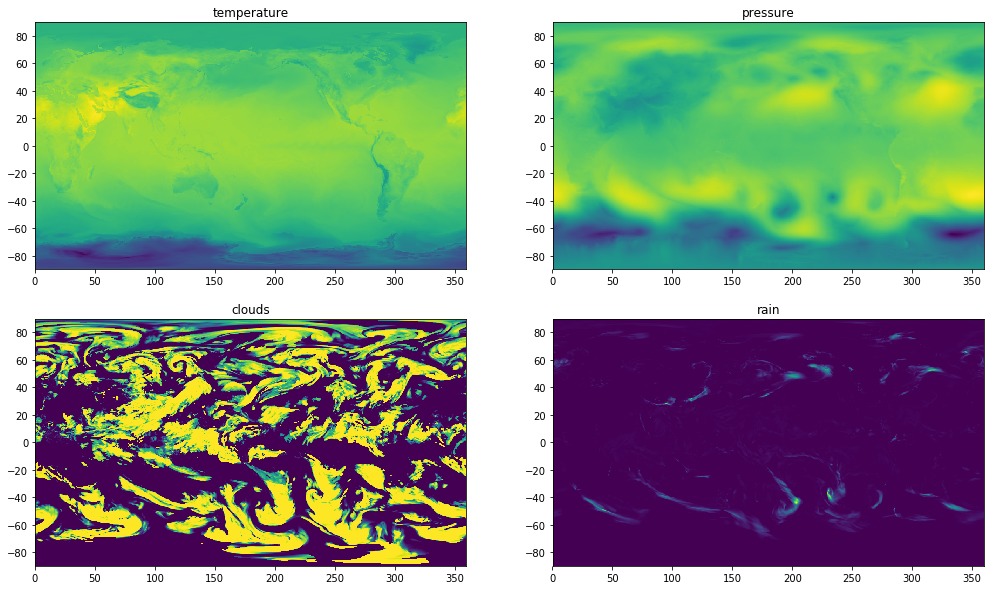

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(17, 10))
ax[0,0].pcolormesh(dataset.variables['longitude'], dataset.variables['latitude'], dataset.variables['air_temperature_0'])
ax[0,0].set_title('temperature')
ax[0,1].pcolormesh(dataset.variables['longitude'], dataset.variables['latitude'], dataset.variables['air_pressure_at_sea_level'])
ax[0,1].set_title('pressure')
ax[1,0].pcolormesh(dataset.variables['longitude'], dataset.variables['latitude'], dataset.variables['high_type_cloud_area_fraction'])
ax[1,0].set_title('clouds')
ax[1,1].pcolormesh(dataset.variables['longitude'], dataset.variables['latitude'], dataset.variables['stratiform_rainfall_amount'])
ax[1,1].set_title('rain')
plt.show()

In [4]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

import netCDF4
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot,
    plot_signal_histogram)
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.calibration import (calibrate_sobel)

# Settings

In [3]:
data_folder = Path("/mnt/Knolselderij/bulk/Abrupt/")
month = 3

sigma_d = unit('1000 km')
sigma_t = unit('10 year')

gamma = 1
scaling_factor = gamma * unit('10 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

model = 'HadGEM2-ES'
variable = 'treeFrac'

data_set = DataSet.cmip5(
    path=data_folder,
    model=model,  # 'GFDL-ESM2M', # 'GFDL-CM3',  # 'GFDL-ESM2G',
    variable=variable,
    scenario='rcp85',
    realization='r1i1p1',
)[month-1::12]

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [4]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.985626 year, 138.994 km, 208.49 km) per pixel
2004-01-10, 2005-01-04, 2005-12-30,  ...
time steps: max 360.0 min 360.0


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

In [5]:
plt.rcParams['font.family'] = 'serif'
my_cmap = matplotlib.cm.get_cmap('BuGn')
my_cmap.set_under('#cceeff')
fig = plot_mollweide(box, data_set.data[0].filled(-1.0), vmin=0.0, cmap=my_cmap)
fig.suptitle("Tree coverage in HadGEM2-ES RCP85 t=2004-01-10")
fig.savefig("tree-coverage.pdf", bbox_inches='tight')

# Calibration

In [5]:
control_set = DataSet.cmip5(
    path=data_folder, model=model, variable=variable,
    scenario='piControl', realization='r1i1p1')[month-1::12]

control_data = control_set.data
control_box = control_set.box

In [6]:
taper_masked_area(control_data, [0, 5, 5], 200)

In [8]:
def earth_plot(
        box, value,
        projection=ccrs.PlateCarree(central_longitude=180),
        transform=ccrs.RotatedPole(pole_longitude=180, pole_latitude=90),
        patch_greenwich=False,
        patch_north_pole=False,
        **pargs):

    lons = box.lon.copy()
    lats = box.lat.copy()

    if patch_greenwich:
        value = np.concatenate([value[:, :], value[:, 0:1]], axis=1)
        lons = np.concatenate([lons, lons[0:1]])

    if patch_north_pole:
        lats = np.concatenate([lats, [90.0]])
        value = np.concatenate([value[:, :], value[0:1, :]], axis=0)

    fig = plt.figure(figsize=(12, 4.5))
    ax = fig.add_subplot(111, projection=projection)
    pcm = ax.pcolormesh(
        lons, lats, value, **pargs,
        transform=transform)
    ax.contour(lons, lats, value, transform=transform, levels=np.linspace(0, 100, 11),
               linewidths=0.5, colors='k', linestyles='dotted')
    ax.set_rasterized(True)
    ax.coastlines()
    fig.colorbar(pcm, label='% tree coverage')
    # plt.close()
    return fig

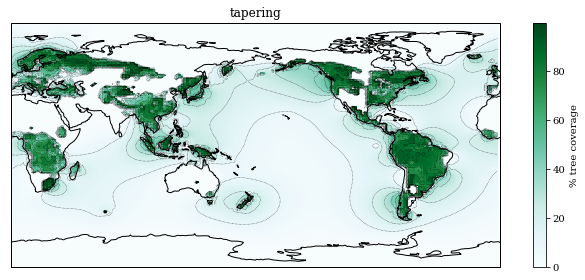

In [9]:
plt.rcParams['font.family'] = 'serif'
earth_plot(control_box, control_data[100].data, cmap='BuGn')
plt.title('tapering')
plt.savefig('tapering.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
smooth_control_data = gaussian_filter(control_box, control_data, [sigma_t, sigma_d, sigma_d])

In [8]:
calibration = calibrate_sobel(3, control_box, smooth_control_data, sobel_delta_t, sobel_delta_d)

for k, v in calibration.items():
    print("{:10}: {}".format(k, v))
print("recommended setting for gamma: ", calibration['gamma'][3])

time      : [0.         0.00081634 0.00248451 0.00551449 0.0645936 ]
distance  : [3.27854591e-04 1.13658565e-01 1.95133901e-01 2.81346513e-01
 5.21905277e-01]
magnitude : [2.89522735e-09 2.61889674e-04 7.53404509e-04 1.55778949e-03
 6.09552673e-03]
gamma     : [0.         0.00718236 0.01273233 0.01960036 0.12376499]
recommended setting for gamma:  0.01960035699248266


In [9]:
gamma_cal = calibration['gamma'][4]
scaling_factor = gamma_cal * unit('10 km/year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

mag_quartiles = np.sqrt((calibration['distance'] * gamma_cal)**2 + calibration['time']**2)

In [37]:
mag_quartiles

array([1.00104711e-05, 1.13278792e-02, 2.03172055e-02, 3.03173890e-02,
       8.50016320e-02])

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [38]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [10]:
data = data_set.data

taper_masked_area(data, [0, 5, 5], 100)
smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [11]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)
pixel_sb[3] = sb[3]

### Determine proper hysteresis settings

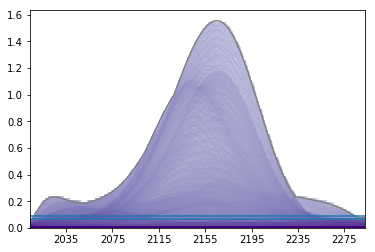

In [12]:
signal = (1.0 / sb[3]).filled(0.0)
plot_signal_histogram(box, signal, mag_quartiles[4]*3/4, mag_quartiles[4]);

In [13]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [14]:
threshold_a = mag_quartiles[4] * 0.95
threshold_b = mag_quartiles[4]

# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

In [15]:
thinned *= ~data.mask
thinned[:10] = 0
thinned[-10:] = 0

In [16]:
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/threshold_b, b=1/threshold_a)
m = edges.transpose([2, 1, 0])

In [38]:
labels, n_features = ndimage.label(m, ndimage.generate_binary_structure(3, 3))
print(n_features)

42


In [43]:
big_enough = [x for x in range(1, n_features+1) if (labels==x).sum() > 400]
print(big_enough)
labels = np.where(np.isin(labels, big_enough), labels, 0)

[1, 2, 5, 8, 9, 15, 19, 32]


In [47]:
perm = np.zeros(50, dtype='int')
perm[big_enough] = arange(1,len(big_enough)+1)

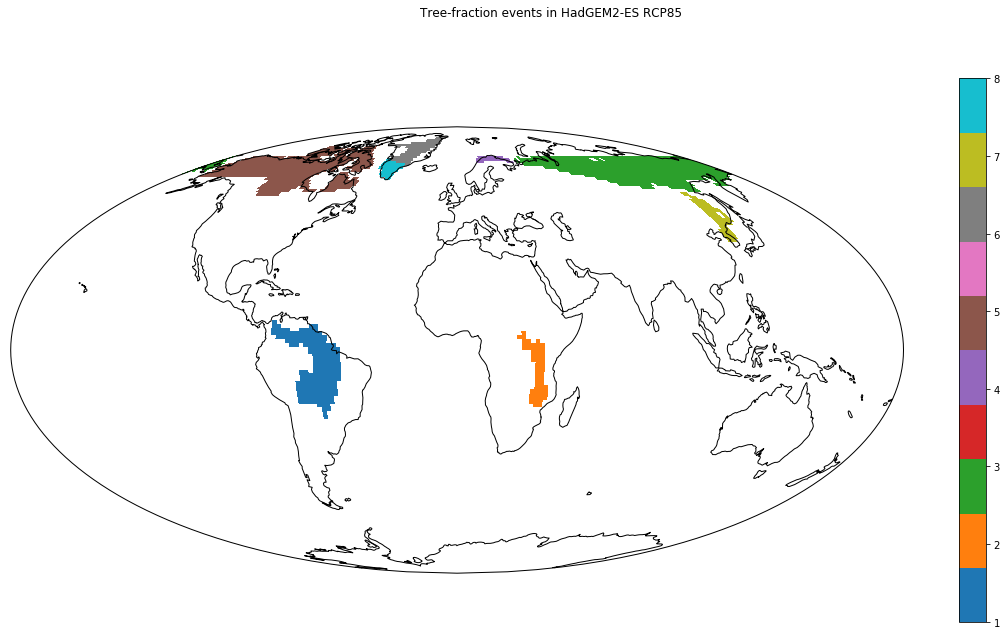

In [49]:
my_cmap = matplotlib.cm.get_cmap('tab10')
my_cmap.set_under('w')
fig = plot_mollweide(box, perm[labels.max(axis=0)], cmap=my_cmap, vmin=1)
fig.suptitle("Tree-fraction events in HadGEM2-ES RCP85")
fig.savefig("tipping_regions.pdf", bbox_inches='tight')
fig

In [32]:
dx = np.sqrt(sb[1]**2 + sb[2]**2)/sb[3] * unit('1/year') / scaling_factor
dt = sb[0]/sb[3] * unit('1/year')
h, xe, te = np.histogram2d(dx.compressed(), dt.compressed(), bins=50)

/home/johannes/.local/share/workon/abrupt/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


/home/johannes/.local/share/workon/abrupt/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


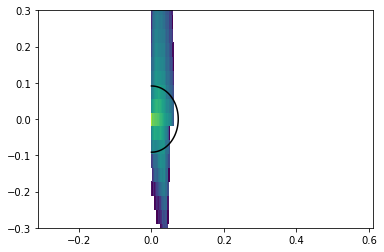

In [33]:
plt.pcolormesh(xe, te, h.T, norm=matplotlib.colors.LogNorm(vmin=10, vmax=h.max()))
dp = np.linspace(-np.pi/2, np.pi/2, 100)
dt = mag_quartiles[4] * sin(dp)
dx = mag_quartiles[4] * cos(dp) * unit('1/year') / scaling_factor
# plt.xlim(0, 0.06)
plt.plot(dx, dt, c='k')
plt.ylim([-0.30, 0.30])
plt.xlim([0,0.3])
plt.axes().set_aspect('equal', 'datalim')

Text(0.5,0,'%/km')

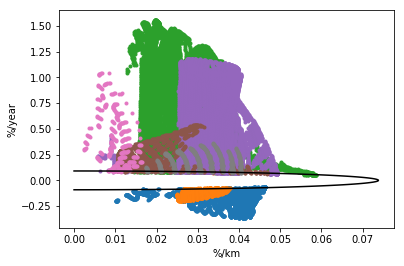

In [34]:
def feature_stats(i):
    idx = np.where(np.logical_and(m, labels == i))
    sobel = sb[:, idx[0], idx[1], idx[2]].data
    dx = np.sqrt(sobel[1]**2 + sobel[2]**2)
    signal = 1./sobel[3]
    return {
        'dx': dx/sobel[3] * unit('1/year') / scaling_factor,
        'dt': sobel[0]/sobel[3] * unit('1/year'),
        'theta': 180/np.pi * np.arctan2(dx, sobel[0]),
        'idx': idx
    }

for i in big_enough:
    stats = feature_stats(i)
    plt.plot(stats['dx'], stats['dt'], '.') ;

dp = np.linspace(-np.pi/2, np.pi/2, 100)
dt = mag_quartiles[4] * sin(dp)
dx = mag_quartiles[4] * cos(dp) * unit('1/year') / scaling_factor
# plt.xlim(0, 0.06)
plt.plot(dx, dt, c='k')
plt.ylabel('%/year')
plt.xlabel('%/km')

In [50]:
years = np.array([d.year for d in box.dates])
fig = plot_mollweide(box, (years[:,None,None]*(labels > 0)).max(axis=0),  cmap='YlGnBu', vmin=2000)
fig.savefig("change-year.pdf", bbox_inches='tight')

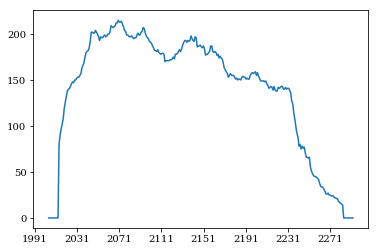

In [39]:
plt.plot(box.dates, m.sum(axis=1).sum(axis=1))
plt.show()

# PI Control

In [45]:
sbc = sobel_filter(control_box, smooth_control_data, weight=sobel_weights)

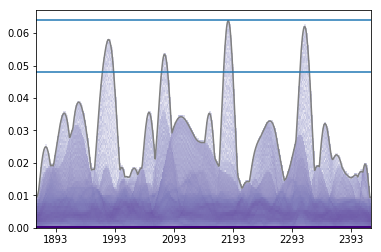

In [50]:
signal = (1.0 / sbc[3]).filled(0.0)
plot_signal_histogram(control_box, signal, threshold_a, threshold_b);

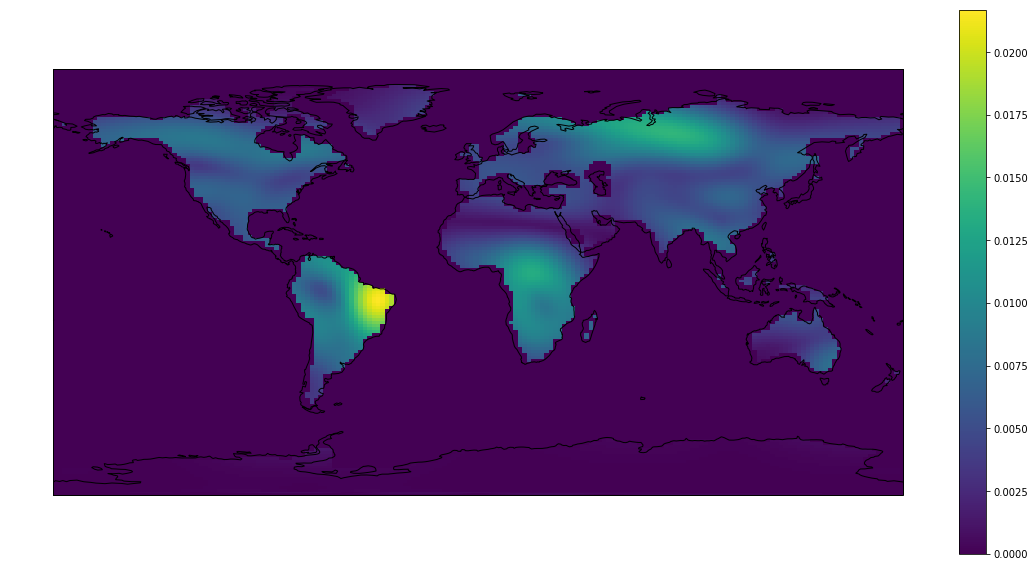

In [49]:
plot_plate_carree(control_box, (1./sbc[3]).mean(axis=0))